In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




In [3]:
combined_stats = pd.read_csv('Data/2025FantasyFootballProjections.csv')

### Criteria of the Dataset:
* HealthGrade = Basic Health Score (Based on Availability Only) for veterans, Case by Case basis for backups, and assuming 2025 Rookies will be healthy.
* HealthStatus = 0 - Healthy/Healthy Backup (16-17 games or being a healthy backup), 1 - Minor Injuries (14-15 games), 2 - Moderate Injuries (10-13 games), 3 - Major Injuries (5-9 games), 4 - Significant Injuries (0-4 games).

In [6]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthGrades,2023HealthGrades2,2023Cmp,2023Att,...,2025Int,2025RushAtt,2025RushYds,2025RushTD,2025Rec,2025RecYds,2025RecTD,2025FL,2025TD,2025PPR
0,1,Josh Allen,BUF,QB,27,17,0,Healthy,385,579,...,6,113.0,561,10,0,0,0,2,41,431.3
1,2,Christian McCaffrey,SF,RB,27,16,0,Healthy,0,0,...,0,217.0,1072,7,64,611,4,2,11,292.6
2,3,CeeDee Lamb,DAL,WR/TE,24,17,0,Healthy,0,0,...,0,14.0,75,0,113,1387,8,1,8,304.6
3,4,Jalen Hurts,PHI,QB,25,17,0,Healthy,352,538,...,9,165.0,754,12,0,0,0,4,40,422.8
4,5,Tyreek Hill,MIA,WR/TE,29,16,0,Healthy,0,0,...,0,8.0,47,0,92,1161,8,0,8,261.0


In [8]:
combined_stats.groupby('FantPos')['2025PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,283.415789,120.582468,15.7,270.55,315.3,356.35,450.0
RB,88.0,141.922727,81.358714,35.3,82.05,125.6,192.45,316.9
WR/TE,155.0,164.665806,62.671227,0.0,126.90,144.8,195.10,367.1


In [10]:
combined_stats.groupby('FantPos')['2024PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,211.552632,120.740111,0.0,126.375,213.2,304.775,434.4
RB,88.0,134.121591,91.854596,0.0,61.325,125.9,200.400,362.9
WR/TE,155.0,128.310968,80.842617,0.0,66.750,122.7,184.450,403.0


In [12]:
combined_stats.groupby('FantPos')['2023/2024AVG'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,207.015789,106.935222,0.0,125.3875,228.425,278.40,388.85
RB,88.0,122.658523,87.959401,0.0,48.4000,117.950,192.85,302.50
WR/TE,155.0,134.629355,74.850309,0.0,84.1000,125.100,185.95,333.30


In [14]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           281 non-null    int64  
 1   Player                       281 non-null    object 
 2   Tm                           281 non-null    object 
 3   FantPos                      281 non-null    object 
 4   2023Age                      281 non-null    int64  
 5   2023G                        281 non-null    int64  
 6   2023HealthGrades             281 non-null    int64  
 7   2023HealthGrades2            281 non-null    object 
 8   2023Cmp                      281 non-null    int64  
 9   2023Att                      281 non-null    int64  
 10  2023PassYds                  281 non-null    int64  
 11  2023PassTD                   281 non-null    int64  
 12  2023Int                      281 non-null    int64  
 13  2023RushAtt         

In [16]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [18]:
# Run a for loop through the Python list (numeric_columns) and use the pd.to_numeric method to change these columns to numeric numbers.
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

## Evaluate data using Train, Test, and Split with Random Forest Regressor.

In [21]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    # print(position_data.head())
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

        
      # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model
    rf = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42
    )
    #Train the Random Forest model using the known historical stats and traits (X_train) to predict the 2025PPR target variable (y_train).
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    train_df = position_data.loc[idx_train, ['Player', 'FantPos', 'Rookie', '2025PPR']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'Predicted Fantasy Points'] = y_pred_train

    test_df = position_data.loc[idx_test, ['Player', 'FantPos', 'Rookie', '2025PPR']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'Predicted Fantasy Points'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True)

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', '2024TD', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']


# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict('RB', rb_features)
wrte_predictions = train_and_predict('WR/TE', wrte_features)
# te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(2)

# The override_dict is used to find specific players (like Tank Dell) in the DataFrame and update their projected points and notes accordingly
# Looping through dictionary to find specific players.
override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_RFR.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Rookie', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 11.062022176870734
RB - Testing MAE: 34.66984814814816

RB - Feature Importances:
          Feature  Importance
7     2024RushAtt    0.463295
9      2024RushTD    0.197611
11     2024RecYds    0.085426
17  ProjectedRole    0.058576
10        2024Rec    0.057995
8     2024RushYds    0.021928
4       2023RecTD    0.019202
3         2023Rec    0.016164
1     2023RushYds    0.013301
15        2025Age    0.011337
12      2024RecTD    0.010632
0     2023RushAtt    0.008521
16   AdjustedRisk    0.008379
14    HealthGrade    0.007219
13         2024FL    0.007093
2      2023RushTD    0.004883
6          2023TD    0.004624
5          2023FL    0.003814

WR/TE - Training MAE: 10.543040112645466
WR/TE - Testing MAE: 31.72611406258966

WR/TE - Feature Importances:
          Feature  Importance
10        2024Rec    0.691591
11     2024RecYds    0.056940
3         2023Rec    0.053098
12      2024RecTD    0.041944
1     2023RushYds    0.021131
14    HealthGrade    0.017755
17  Pro

* R²: Measures how well the model’s predictions match the real values — 1.0 is a perfect score, and 0.0 means the model performs no better than just predicting the mean.

* MAE: Gives the average difference between actual and predicted health grades — lower is better.

In [24]:
# Evaluate R² and MAE by position
# Start with an empty Python list
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})
    
# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.886  15.89
1    WR/TE  0.877  14.39
2       QB  0.826  29.27


In [26]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list
position_metrics = []

# Filter for test data only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

for pos in test_only['FantPos'].unique():
    subset = test_only[test_only['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position: (Testing)")
print(position_metrics_df)


Performance Metrics by Position: (Testing)
  Position     R²    MAE
0       RB  0.487  34.67
1    WR/TE  0.401  31.73
2       QB -0.071  71.66


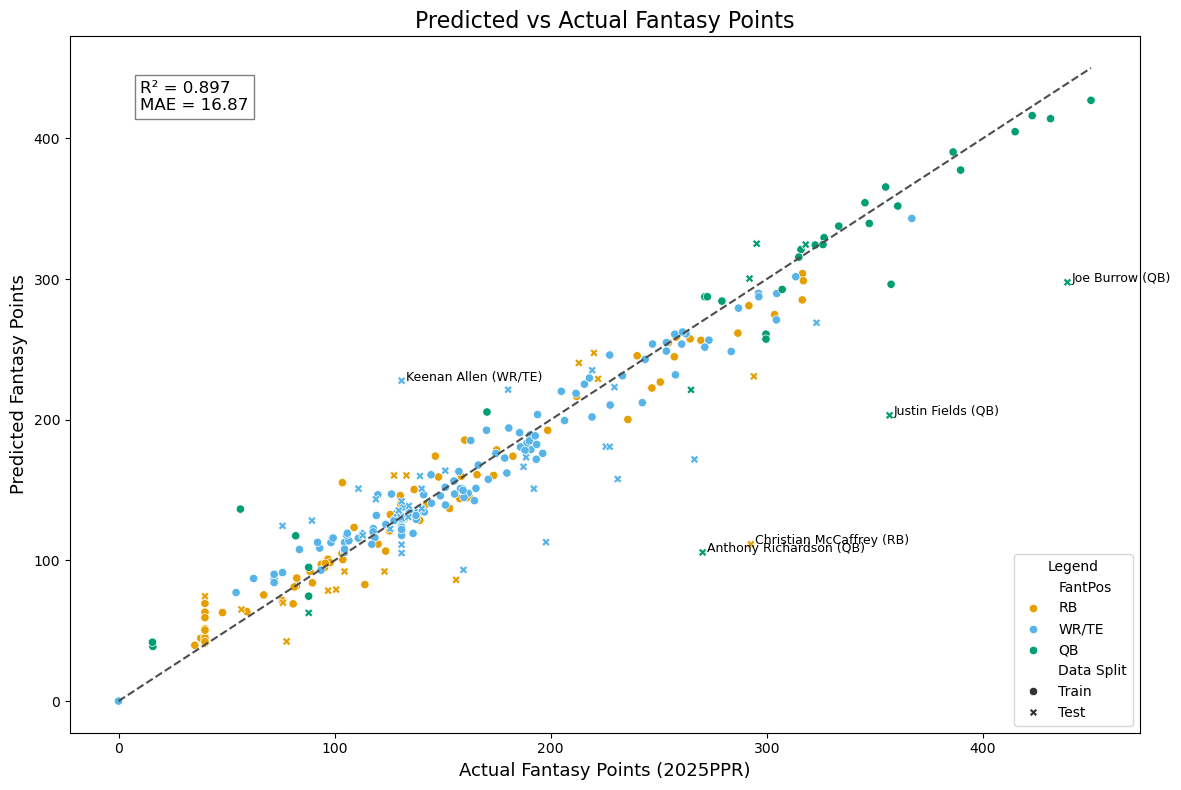

In [28]:

# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility
# 'TE': '#F0E442',   # yellow
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'QB': '#009E73',  # green
}
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=all_predictions,
    x='2025PPR', y='Predicted Fantasy Points',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['2025PPR'].min()
max_val = all_predictions['2025PPR'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual Fantasy Points', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

In [30]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['2025PPR']

In [32]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
                Player FantPos  2025PPR  Predicted Fantasy Points  \
138       Keenan Allen   WR/TE    131.0                    227.72   
26        Daniel Jones      QB     56.4                    136.46   
23         Rico Dowdle      RB    103.6                    155.25   
154      Tommy Tremble   WR/TE     75.9                    124.52   
137  Wan'Dale Robinson   WR/TE    180.3                    221.36   
131     Jayden Higgins   WR/TE    111.0                    150.97   
130      Josh Reynolds   WR/TE     89.5                    128.28   
21        Kirk Cousins      QB     82.0                    117.48   
14        Tyler Shough      QB    170.5                    205.46   
79       Carson Steele      RB     40.0                     74.51   

     ValuationDiff  
138          96.72  
26           80.06  
23           51.65  
154          48.62  
137          41.06  
131          39.97  
130          38.78  
21           35.48  
14           34.96

In [34]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                  Player FantPos Data Split  2025PPR  \
71   Christian McCaffrey      RB       Test    292.6   
33    Anthony Richardson      QB       Test    270.3   
37         Justin Fields      QB       Test    356.8   
36            Joe Burrow      QB       Test    439.1   
126          Rashee Rice   WR/TE       Test    266.5   
144     Deebo Samuel Sr.   WR/TE       Test    197.8   
127         Chris Godwin   WR/TE       Test    231.0   
86             Zack Moss      RB       Test    156.2   
124          Taysom Hill   WR/TE       Test    159.6   
76         Derrick Henry      RB       Test    294.0   

     Predicted Fantasy Points  ValuationDiff  
71                     111.45        -181.15  
33                     105.69        -164.61  
37                     203.14        -153.66  
36                     297.69        -141.41  
126                    171.82         -94.68  
144                    112.94         -84.86  
127                 

#### Cross-validation (CV), especially k-fold cross-validation, allows you to:

* Test the model’s generalization ability:

* Train the model on part of the data and test it on a separate fold.
* This mimics real-world prediction where the model sees new players or new seasons.
* Get a more reliable performance estimate:

* It smooths out performance variation that might occur from a lucky or unlucky split.
* Avoid data leakage and overfitting:

* Each prediction is made on data the model hasn’t seen, so the reported performance is more honest.
* Cross-validation is a method to simulate real-world performance and reduce overfitting risk.

* The Random Forest Regression model’s performance on the training data shows how well it can fit the data it has seen, while 5-fold cross-validation evaluates how well the model generalizes to unseen data.

#### What 5-Fold Cross-Validation Does:

* It splits your full dataset into 5 equal-sized parts (called "folds").

* It runs 5 training/testing cycles — in each cycle:

* It uses 4 folds (80%) for training

* And 1 fold (20%) for testing

* Each fold gets to be the test set exactly once.

* It systematically rotates through the dataset so that every example is tested once and only once.

## Now we will use Cross Validation to determine the 2025 fantasy football projected scores.

In [38]:
# Function to train and predict for a specific position using cross-validation

def train_and_predict_cv(position, features):
    # Filter data for the specific position
    # position_data is a filtered copy of combined_stats based on the given position.
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Adjust number of folds based on data size
    n_samples = len(position_data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get out-of-fold predictions (no leakage)
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Calculate CV MAE
    mae = mean_absolute_error(y, y_pred)
    print(f"\n{position} - Cross-Validated MAE: {mae:.2f}")

    # Fit the model on the full dataset to get final feature importances
    rf.fit(X, y)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['Predicted Fantasy Points'] = y_pred

    return position_data[['Player', 'FantPos', 'Rookie', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', 
               '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds',
                 '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']

# Train and predict for each position
rb_predictions = train_and_predict_cv('RB', rb_features)
wrte_predictions = train_and_predict_cv('WR/TE', wrte_features)
# te_predictions = train_and_predict_cv('TE', te_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(2)

override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_CV.csv"
all_predictions[['Player', 'FantPos', 'Rookie', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE: 31.53

RB - Feature Importances:
          Feature  Importance
17  ProjectedRole    0.289038
7     2024RushAtt    0.268713
9      2024RushTD    0.170246
11     2024RecYds    0.080941
10        2024Rec    0.023711
6          2023TD    0.022809
8     2024RushYds    0.020608
1     2023RushYds    0.019442
12      2024RecTD    0.016871
2      2023RushTD    0.016680
3         2023Rec    0.012355
4       2023RecTD    0.010568
16   AdjustedRisk    0.010169
15        2025Age    0.009946
0     2023RushAtt    0.009252
14    HealthGrade    0.007630
13         2024FL    0.006990
5          2023FL    0.004032

WR/TE - Cross-Validated MAE: 27.44

WR/TE - Feature Importances:
          Feature  Importance
10        2024Rec    0.620581
11     2024RecYds    0.093909
3         2023Rec    0.084609
12      2024RecTD    0.037866
15        2025Age    0.021933
14    HealthGrade    0.021506
17  ProjectedRole    0.019008
1     2023RushYds    0.017922
16   AdjustedRisk    0.014815
7   

In [40]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.727  31.53
1    WR/TE  0.684  26.38
2       QB  0.572  60.11


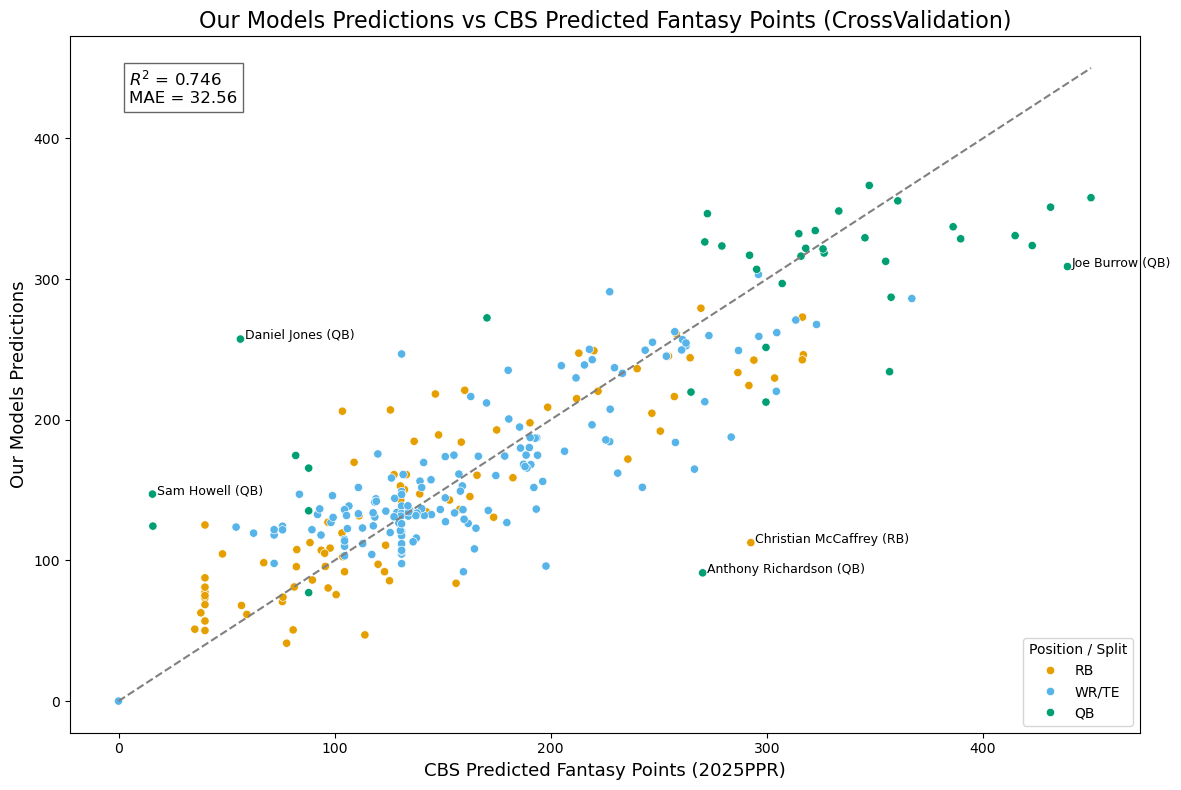

In [42]:

# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'TE': '#F0E442',  # yellow
    'QB': '#009E73',  # green 
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Our Models Predictions vs CBS Predicted Fantasy Points (CrossValidation)', fontsize=16)
plt.xlabel('CBS Predicted Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Our Models Predictions', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [44]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['2025PPR']

In [46]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
                 Player FantPos  2025PPR  Predicted Fantasy Points  \
39         Daniel Jones      QB     56.4                    257.32   
137          Sam Howell      QB     15.7                    147.12   
48         Keenan Allen   WR/TE    131.0                    246.71   
181     Aidan O'Connell      QB     15.9                    124.37   
175         Rico Dowdle      RB    103.6                    206.04   
280        Tyler Shough      QB    170.5                    272.38   
72         Kirk Cousins      QB     82.0                    174.58   
171  Alexander Mattison      RB     40.0                    125.17   
26   Travis Etienne Jr.      RB    125.8                    206.95   
37           Will Levis      QB     88.0                    165.59   

     ValuationDiff  
39          200.92  
137         131.42  
48          115.71  
181         108.47  
175         102.44  
280         101.88  
72           92.58  
171          85.17  
26     

In [48]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                  Player FantPos  2025PPR  Predicted Fantasy Points  \
1    Christian McCaffrey      RB    292.6                    112.62   
21    Anthony Richardson      QB    270.3                     91.14   
10            Joe Burrow      QB    439.1                    308.87   
129        Justin Fields      QB    356.8                    234.12   
52      Deebo Samuel Sr.   WR/TE    197.8                     95.96   
69           Rashee Rice   WR/TE    266.5                    164.87   
3            Jalen Hurts      QB    422.8                    323.78   
36          Nico Collins   WR/TE    283.5                    187.65   
5          Lamar Jackson      QB    450.0                    357.81   
109        Xavier Worthy   WR/TE    242.4                    151.95   

     ValuationDiff  
1          -179.98  
21         -179.16  
10         -130.23  
129        -122.68  
52         -101.84  
69         -101.63  
3           -99.02  
36          -95.

## Combined CV + Full-Training Prediction Function

* Combined version of train_and_predict_cv function that:
* Uses cross_val_predict to evaluate out-of-fold performance (for realistic MAE).
* Fits a final model on the full data to generate actual predicted fantasy points (for production use).
* Returns both the evaluation metrics and full-data predictions.

In [51]:
def train_and_predict_cv_ft(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Initialize model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

    # Adjust number of folds based on data size
    n_samples = len(position_data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    # Cross-validation strategy
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Step 1: Cross-validated prediction
    y_pred_cv = cross_val_predict(rf, X, y, cv=kf)
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"\n{position} - Cross-Validated MAE (unseen): {mae_cv:.2f}")

    # Step 2: Final model trained on all data
    rf.fit(X, y)
    y_pred_final = rf.predict(X)

    # Feature importances
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Create output DataFrame
    cv_df = position_data.copy()
    cv_df['Predicted Fantasy Points'] = np.round(y_pred_cv, 2)
    cv_df['Data Split'] = 'CrossVal'
    
    ft_df = position_data.copy()
    ft_df['Predicted Fantasy Points'] = np.round(y_pred_final, 2)
    ft_df['Data Split'] = 'FullTrain'

    # Combine CV and FT predictions
    combined_df = pd.concat([cv_df, ft_df], ignore_index=True)
    
    return combined_df[['Player', 'FantPos', 'Rookie', 'Data Split', 'Predicted Fantasy Points', '2025PPR']]


# Define feature sets for each position
# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']

# Train and predict for each position
rb_predictions = train_and_predict_cv_ft('RB', rb_features)
wrte_predictions = train_and_predict_cv_ft('WR/TE', wrte_features)
# te_predictions = train_and_predict_cv_ft('TE', te_features)
qb_predictions = train_and_predict_cv_ft('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions])

# Initialize Note column
all_predictions['Note'] = ''

# Manual overrides (e.g., injury status)
override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Create side-by-side comparison
side_by_side = all_predictions.pivot_table(
    index=['Player', 'FantPos', 'Rookie', '2025PPR'],
    columns='Data Split',
    values='Predicted Fantasy Points'
).reset_index()

# Rename columns for clarity
side_by_side.columns = ['Player', 'FantPos', 'Rookie', '2025PPR', 'Predicted Fantasy Points (CV)', 'Predicted Fantasy Points (FT)']

# Sort by FantPos (ascending) and 2025PPR (descending)
side_by_side = side_by_side.sort_values(by=['FantPos', '2025PPR'], ascending=[True, False])

# Calculate residuals
side_by_side['Residual_CV'] = (side_by_side['Predicted Fantasy Points (CV)'] - side_by_side['2025PPR']).round(1)
side_by_side['Residual_FT'] = (side_by_side['Predicted Fantasy Points (FT)'] - side_by_side['2025PPR']).round(1)

# Save results
# all_predictions[['Player', 'FantPos', 'Data Split', 'Predicted Fantasy Points', '2025PPR', 'Note']].to_csv(
#    "Data/FantasyFootballPrediction_CVFT.csv", index=False)
side_by_side.to_csv("Data/FantasyFootballPrediction_CVFT_SideBySide.csv", index=False)

# Save final predictions to CSV
# output_path = "Data/FantasyFootballPrediction_CVFT.csv"
# all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE (unseen): 31.53

RB - Feature Importances:
          Feature  Importance
17  ProjectedRole    0.289038
7     2024RushAtt    0.268713
9      2024RushTD    0.170246
11     2024RecYds    0.080941
10        2024Rec    0.023711
6          2023TD    0.022809
8     2024RushYds    0.020608
1     2023RushYds    0.019442
12      2024RecTD    0.016871
2      2023RushTD    0.016680
3         2023Rec    0.012355
4       2023RecTD    0.010568
16   AdjustedRisk    0.010169
15        2025Age    0.009946
0     2023RushAtt    0.009252
14    HealthGrade    0.007630
13         2024FL    0.006990
5          2023FL    0.004032

WR/TE - Cross-Validated MAE (unseen): 27.44

WR/TE - Feature Importances:
          Feature  Importance
10        2024Rec    0.620581
11     2024RecYds    0.093909
3         2023Rec    0.084609
12      2024RecTD    0.037866
15        2025Age    0.021933
14    HealthGrade    0.021506
17  ProjectedRole    0.019008
1     2023RushYds    0.017922
16   AdjustedRis

* Predicted Fantasy Points (CV): The out-of-fold predictions generated during cross-validation. These simulate how the model would perform on unseen data, giving a more realistic estimate of prediction error.

* Predicted Fantasy Points (Final Model): The predictions made by a model trained on all available data. These are typically more accurate but can be overly optimistic, since the model has seen the full dataset (including each player).

* Predicted Fantasy Points: This is a copy of the Final Model predictions, used as the main output for projections (e.g., fantasy draft prep). It allows for consistent overrides and output formatting.

* 2025PPR: The CBS predicted fantasy points scored by the player for the 2025 season. This is used for error analysis and to evaluate model accuracy after the season.

* Use Predicted Fantasy Points (CV) to evaluate the model's real-world accuracy (MAE, scatterplots, etc.), and use Predicted Fantasy Points (Final Model) or Predicted Fantasy Points for forward-looking projections such as rankings and drafting.

* In most real-world ML pipelines: Use cross-validation to evaluate the model's generalization. Then, train the final model on all data to deploy/predict.

In [54]:
# Filter only CV rows
cv_only = all_predictions[all_predictions['Data Split'] == 'CrossVal']

# Evaluate R² and MAE by position using only CV data
position_metrics = []

for pos in cv_only['FantPos'].unique():
    subset = cv_only[cv_only['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

position_metrics_df = pd.DataFrame(position_metrics)

print("\nCV-Only Performance Metrics by Position:")
print(position_metrics_df)


CV-Only Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.727  31.53
1    WR/TE  0.684  26.38
2       QB  0.572  60.11


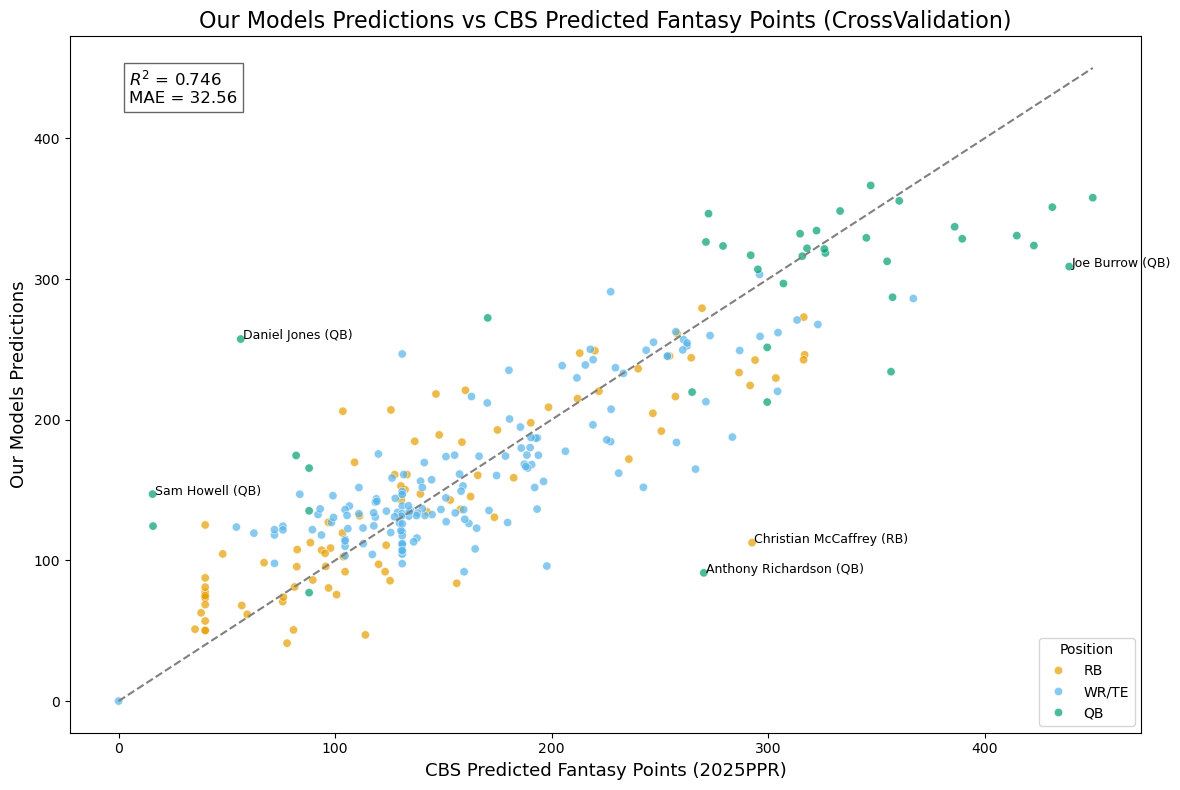

In [56]:
# Filter for CV-only data
cv_only = all_predictions[all_predictions['Data Split'] == 'CrossVal'].copy()

# Calculate CV metrics
r2_cv = r2_score(cv_only['2025PPR'], cv_only['Predicted Fantasy Points'])
mae_cv = mean_absolute_error(cv_only['2025PPR'], cv_only['Predicted Fantasy Points'])

# Calculate residuals
cv_only['Residual_CV'] = np.abs(cv_only['2025PPR'] - cv_only['Predicted Fantasy Points'])

# Get top 5 residual outliers
top_outliers_cv = cv_only.nlargest(5, 'Residual_CV')

# 'TE': '#F0E442',   # yellow
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'QB': '#009E73',  # green
}

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cv_only,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette,
    alpha=0.7
)

# Diagonal reference line
min_val = min(cv_only['2025PPR'].min(), cv_only['Predicted Fantasy Points'].min())
max_val = max(cv_only['2025PPR'].max(), cv_only['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 outliers
for _, row in top_outliers_cv.iterrows():
    plt.text(row['2025PPR'] + 1, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Our Models Predictions vs CBS Predicted Fantasy Points (CrossValidation)', fontsize=16)
plt.xlabel('CBS Predicted Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Our Models Predictions', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_cv:.3f}\nMAE = {mae_cv:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position', loc='lower right')
plt.tight_layout()
plt.show()

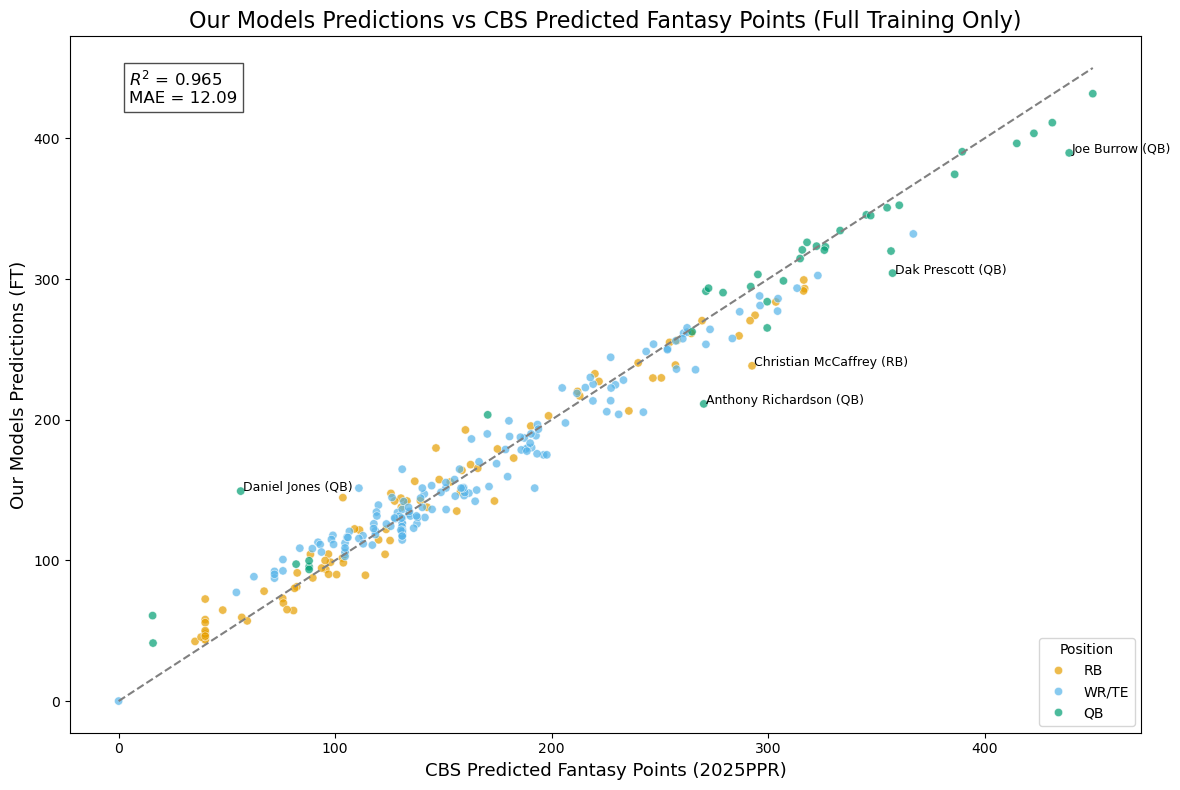

In [58]:
# Filter for Full Training-only data
ft_only = all_predictions[all_predictions['Data Split'] == 'FullTrain'].copy()

# Calculate Full Training metrics
r2_ft = r2_score(ft_only['2025PPR'], ft_only['Predicted Fantasy Points'])
mae_ft = mean_absolute_error(ft_only['2025PPR'], ft_only['Predicted Fantasy Points'])

# Calculate residuals
ft_only['Residual_FT'] = np.abs(ft_only['2025PPR'] - ft_only['Predicted Fantasy Points'])

# Get top 5 residual outliers
top_outliers_ft = ft_only.nlargest(5, 'Residual_FT')

# Colorblind-friendly palette for fantasy positions
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'TE': '#F0E442',   # yellow
    'QB': '#009E73',  # green
}

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=ft_only,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette,
    alpha=0.7
)

# Diagonal reference line
min_val = min(ft_only['2025PPR'].min(), ft_only['Predicted Fantasy Points'].min())
max_val = max(ft_only['2025PPR'].max(), ft_only['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 outliers
for _, row in top_outliers_ft.iterrows():
    plt.text(row['2025PPR'] + 1, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Our Models Predictions vs CBS Predicted Fantasy Points (Full Training Only)', fontsize=16)
plt.xlabel('CBS Predicted Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Our Models Predictions (FT)', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_ft:.3f}\nMAE = {mae_ft:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Legend and layout
plt.legend(title='Position', loc='lower right')
plt.tight_layout()
plt.show()

In [60]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['2025PPR']

In [62]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
                Player FantPos Data Split  2025PPR  Predicted Fantasy Points  \
20        Daniel Jones      QB   CrossVal     56.4                    257.32   
28          Sam Howell      QB   CrossVal     15.7                    147.12   
15        Keenan Allen   WR/TE   CrossVal    131.0                    246.71   
29     Aidan O'Connell      QB   CrossVal     15.9                    124.37   
47         Rico Dowdle      RB   CrossVal    103.6                    206.04   
37        Tyler Shough      QB   CrossVal    170.5                    272.38   
58        Daniel Jones      QB  FullTrain     56.4                    149.24   
23        Kirk Cousins      QB   CrossVal     82.0                    174.58   
45  Alexander Mattison      RB   CrossVal     40.0                    125.17   
3   Travis Etienne Jr.      RB   CrossVal    125.8                    206.95   

    ValuationDiff  
20         200.92  
28         131.42  
15         115.71  
29    

In [64]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                 Player FantPos Data Split  2025PPR  Predicted Fantasy Points  \
0   Christian McCaffrey      RB   CrossVal    292.6                    112.62   
13   Anthony Richardson      QB   CrossVal    270.3                     91.14   
6            Joe Burrow      QB   CrossVal    439.1                    308.87   
27        Justin Fields      QB   CrossVal    356.8                    234.12   
18     Deebo Samuel Sr.   WR/TE   CrossVal    197.8                     95.96   
31          Rashee Rice   WR/TE   CrossVal    266.5                    164.87   
1           Jalen Hurts      QB   CrossVal    422.8                    323.78   
10         Nico Collins   WR/TE   CrossVal    283.5                    187.65   
2         Lamar Jackson      QB   CrossVal    450.0                    357.81   
53        Xavier Worthy   WR/TE   CrossVal    242.4                    151.95   

    ValuationDiff  
0         -179.98  
13        -179.16  
6         -130

In [66]:
print(all_predictions.columns)

Index(['Player', 'FantPos', 'Rookie', 'Data Split', 'Predicted Fantasy Points',
       '2025PPR', 'Note', 'ValuationDiff'],
      dtype='object')


In [68]:
keenan_allen_data = combined_stats[combined_stats['Player'] == 'Keenan Allen']

In [70]:
print(keenan_allen_data[['Player', '2023PPR', '2024PPR', '2025PPR']])

          Player  2023PPR  2024PPR  2025PPR
48  Keenan Allen    278.9    185.4    131.0


In [72]:
jt_data = combined_stats[combined_stats['Player'] == 'Jonathan Taylor']

In [74]:
print(jt_data[['Player', '2023PPR', '2024PPR', '2025PPR']])

             Player  2023PPR  2024PPR  2025PPR
28  Jonathan Taylor    156.4    244.7    221.9


| Player           | 2023PPR | 2024PPR | 2025PPR | CV   | FT  |
|------------------|---------|---------|---------|------|-----|
| Jonathan Taylor  | 156.4   | 244.7   | 221.9   | 220  | 227 |